In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE_path = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()
line_e = source_dict['Cs137']

sim_dCCE = np.loadtxt(sim_dCCE_path, delimiter=',').T
# print(sim_dCCE)

def e_depth_plot(z, ae, b, c):
    CCE = ae*(1.-b*sim_dCCE[1][::-1])*(1.-c*sim_dCCE[2][::-1])
    return UnivariateSpline(sim_dCCE[0], CCE)(z)

def h_depth_plot(z, ah, b, c):
    CCE = ah*(1.-b*sim_dCCE[3][::-1])*(1.-c*sim_dCCE[4][::-1])
    return UnivariateSpline(sim_dCCE[0], CCE)(z)


21.8 +/- 1.9
19.3 +/- 1.6


/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
zbins_list = []
etrapping_list =[]
htrapping_list = []
fluence_list = [0., 2., 4.95]
label_list = [r'$f=0\,\mathrm{p/cm^2}$', r'$f=2\times10^8\,\mathrm{p/cm^2}$', r'$f=4.95\times10^8\,\mathrm{p/cm^2}$', r'$f=4.95\times10^8\,\mathrm{p/cm^2}\,;T_\mathrm{anneal}=70^{\circ}\mathrm{C}$']
ae_list = [1.00113, 1.004321, 1.004382]
ah_list = [1.000687, 1.003462, 1.002172]
b_list = np.array([1.310, 1.373, 2.127])
c_list = np.array([0.539, 9.399,  27.2447])

pickle_list = ['depth_plot_Cs137allACDC_preLL.txt', 'depth_plot_Cs137allACDC_postLL1.txt', 'depth_plot_Cs137allACDC_postLL2.txt', 'depth_plot_Cs137allACDC_postroomtemp.txt']
for p in pickle_list:
    with open(p, 'rb') as file:
        zbins, etrapping, htrapping = pickle.load(file)
    zbins_list.append(zbins)
    etrapping_list.append(etrapping)
    htrapping_list.append(htrapping)
    

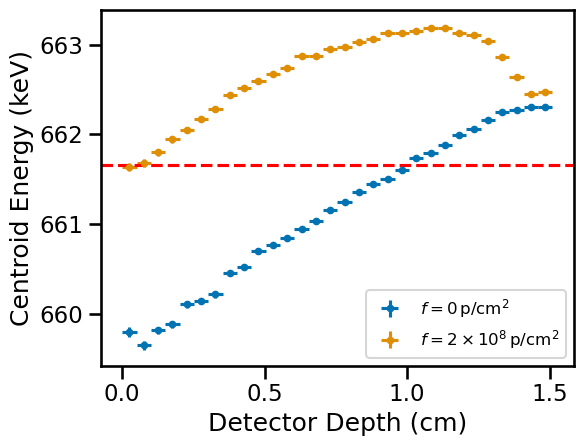

In [44]:
nepochs = 2
plt.figure()
for i in range(nepochs):
    z_bins = zbins_list[i]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.

    plt.errorbar(z_list, etrapping_list[i][0]*line_e, xerr = z_err, yerr=etrapping_list[i][1]*line_e, fmt=".", color='C'+str(i), label=label_list[i])

plt.legend(fontsize=12)
plt.axhline(line_e, ls='--', color='red')
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
plt.tight_layout()
plt.savefig(plot_dir + 'etrapping_Cs137_' + str(nepochs) + 'epochs.pdf')
plt.show()
plt.close()


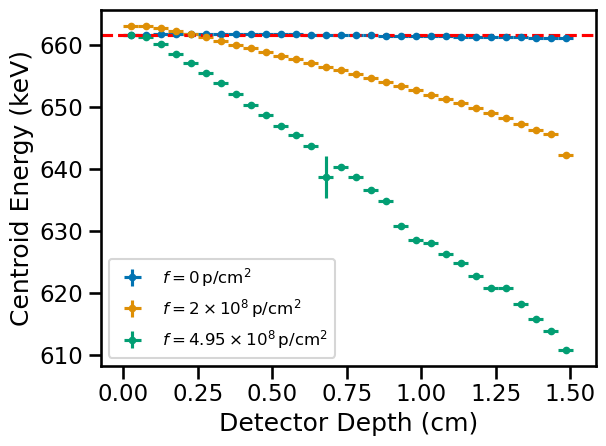

In [46]:
nepochs = 3
plt.figure()
for i in range(nepochs):
    z_bins = zbins_list[i]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.
    
    plt.errorbar(z_list, htrapping_list[i][0]*line_e, xerr = z_err, yerr=htrapping_list[i][1]*line_e, fmt=".", color='C'+str(i), label=label_list[i])
    
    
plt.legend(loc=3,fontsize=12)
plt.axhline(line_e, ls='--', color='red')
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
plt.tight_layout()
plt.savefig(plot_dir + 'htrapping_Cs137_'+str(nepochs)+'epochs.pdf')
plt.show()
plt.close()


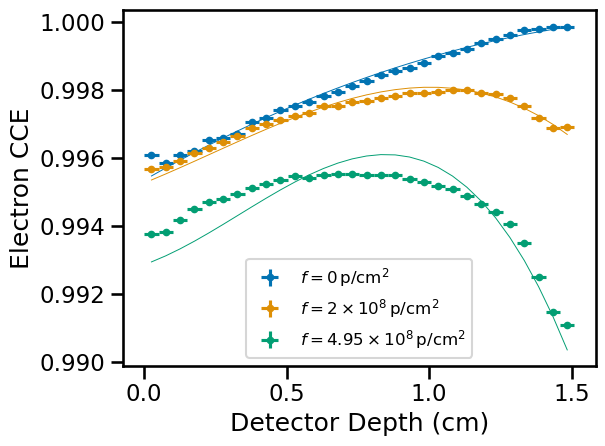

In [10]:
nepochs = 3
plt.figure()
for i in range(nepochs):
    z_bins = zbins_list[i]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.

    plt.errorbar(z_list, etrapping_list[i][0]/ae_list[i], xerr = z_err, yerr=etrapping_list[i][1]/ae_list[i], fmt=".", color='C'+str(i), label=label_list[i])
    plt.plot(z_list, e_depth_plot(z_list, 1.0, b_list[i], c_list[i]), color='C'+str(i), lw=0.7)
    
plt.legend(fontsize=12)
# plt.axhline(line_e, ls='--', color='red')
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Electron CCE")
plt.tight_layout()
plt.savefig(plot_dir + 'etrappingCCE_Cs137_' + str(nepochs) + 'epochs.pdf')
plt.show()
plt.close()


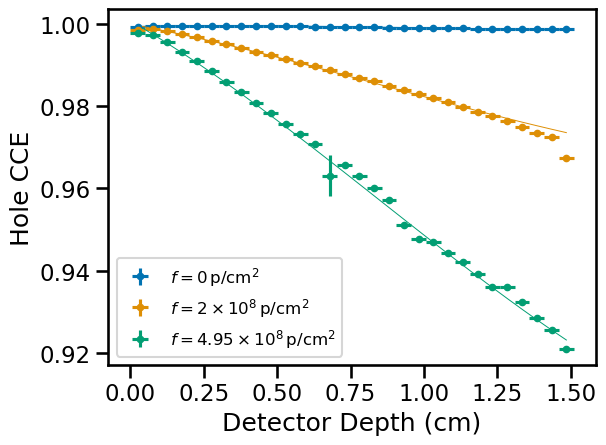

In [11]:
nepochs = 3
plt.figure()
for i in range(nepochs):
    z_bins = zbins_list[i]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.

    plt.errorbar(z_list, htrapping_list[i][0]/ah_list[i], xerr = z_err, yerr=htrapping_list[i][1]/ah_list[i], fmt=".", color='C'+str(i), label=label_list[i])
    plt.plot(z_list, h_depth_plot(z_list, 1.0, b_list[i], c_list[i]), color='C'+str(i), lw=0.7)
                                  
plt.legend(loc=3,fontsize=12)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Hole CCE")
plt.tight_layout()
plt.savefig(plot_dir + 'htrappingCCE_Cs137_'+str(nepochs)+'epochs.pdf')
plt.show()
plt.close()


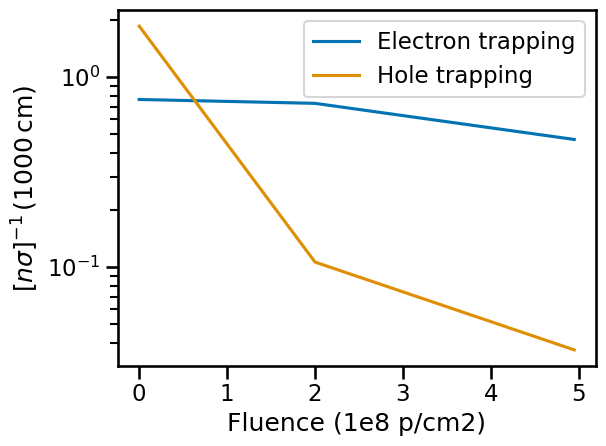

In [18]:
plt.figure()
plt.plot(fluence_list, 1./(b_list), label = 'Electron trapping')
plt.plot(fluence_list, 1./(c_list), label = 'Hole trapping')
plt.yscale('log')
plt.legend()
plt.xlabel('Fluence (1e8 p/cm2)')
plt.ylabel(r'$[n\sigma]^{-1}\,\mathrm{(1000\,cm})$')
plt.tight_layout()
plt.savefig(plot_dir + 'trapping_products_Cs137_.pdf')
plt.show()
plt.close()